In [1]:
# default_exp models.task

In [2]:
from nbdev.showdoc import *
from nbdev.export import *

In [3]:
# export
from typing import Any, Callable, Dict, List, Optional, Union
from collections import OrderedDict, namedtuple

import torch
from hydra.utils import instantiate
from omegaconf import DictConfig
from pytorch_lightning import LightningModule
from pytorch_lightning.metrics import Accuracy
from torch.utils.data import DataLoader

from src import _logger
from src.data import CassavaClassificationModule
from src.models.builder import Net
from src.optimizers import create_optimizer
from src.schedulers import create_scheduler
from fastcore.all import ifnone

In [4]:
# export
class Task(LightningModule):
    "A general Task for Cassave Leaf Disease Classification"
    
    def __init__(self, conf: DictConfig):
        super().__init__()
        self.model = Net(conf)
        self.trn_metric = Accuracy()
        self.val_metric = Accuracy()
        self.tst_metric = Accuracy()
        self.save_hyperparameters(conf)
        
        self.datamodule = CassavaClassificationModule(conf)
        self.datamodule.prepare_data()
        self.datamodule.setup(stage=None, verbose=False)
        self.lrs = namedtuple("LearningRates", ["lr1", "lr2"])

        self.criterion   = instantiate(self.hparams.loss)
        self.mixfunction = instantiate(self.hparams.mixmethod)

        _logger.info(f"LossFunction: {self.criterion}")
        _logger.info(f"MixFunction : {self.mixfunction}")

    def forward(self, x: Any) -> Any:
        return self.model(x)
    
    def step(self, batch: Any, batch_idx: int, stage="train") -> Any:
        """
        The training/validation/test step. Override for custom behavior.
        """ 
        x, y = batch
        self.preds  = None
        self.labels = list(y.data.cpu().numpy())
        
        if stage == "train":
            if self.mixfunction is not None and (self.current_epoch < self.hparams.training.mix_epochs):
                x = mixfunction(x, y, model=self.model)
                logits = self.forward(x)
                loss   = self.mixfunction.lf(logits, loss_func=self.criterion)    
            
            elif self.mixfunction is None or (self.current_epoch >= hparams.training.mix_epochs):
                logits = self.forward(x)
                loss   = self.criterion(logits, y) 
            
            metric = self.trn_metric(logits, y)
        
        elif stage == "valid" or "test":
            logits = self.forward(x)
            loss   = self.criterion(logits, y)
            
            if stage == "valid":
                metric = self.val_metric(logits, y)
            else:
                metric = self.tst_metric(logits, y)
        else:
            raise NameError
            
        preds = torch.argmax(logits, 1)
        self.preds = list(preds)
        
        return dict(loss=loss, metric=metric)
    
    def training_step(self, batch: Any, batch_idx: int) -> Any:
        logs = self.step(batch, batch_idx, stage="train")
        
        self.log_dict(OrderedDict(train_loss=logs['loss'], train_acc=logs['metric']), 
                      on_step=True, on_epoch=True, prog_bar=True)
        
        return logs['loss']
    
    def validation_step(self, batch: Any, batch_idx: int) -> None:
        logs = self.step(batch, batch_idx, stage="valid")
        
        self.log_dict(OrderedDict(val_loss=logs['loss'], val_acc=logs['metric']),
                      on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch: Any, batch_idx: int) -> None:
        logs = self.step(batch, batch_idx, stage="test")
        
        self.log_dict(OrderedDict(test_loss=logs['loss'], test_acc=logs['metric']),
                      on_step=False, on_epoch=True, prog_bar=False)
    
    def configure_optimizers(self) -> (List[torch.optim.Optimizer], List[Dict]):
        params = self.model.get_param_list()
        lrs    = (self.hparams.training.learning_rate/self.hparams.training.lr_mult, 
                  self.hparams.training.learning_rate)
        self.lrs = self.lrs(lrs[0], lrs[1])
        
        epochs = self.hparams.training.num_epochs
        try   : steps = int(self.num_training_steps / epochs)
        except: steps = len(self.train_dataloader())/ self.hparams.training.accumulate_grad_batches
        params = [dict(params=params[0], lr=lrs[0]), dict(params=params[1], lr=lrs[1])]
        
        optim = create_optimizer(self.hparams.optimizer, params)
        sched = create_scheduler(self.hparams.scheduler, optim, steps, epochs)
        return [optim], [sched]
        
    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        "returns a PyTorch DataLoader for Training"
        if self.current_epoch == self.hparams.training.mix_epochs:
            if self.mixfunction is not None:
                self.mixfunction.stop()
            # reset transformations in the datamoule
            self.datamodule.train_ds.reload_transforms(self.trainer.datamodule.augs_final)
        dataloader = self.datamodule.train_dataloader()
        return dataloader
    
    def val_dataloader(self, *args, **kwargs) -> DataLoader:
        "returns a PyTorch DataLoader for Validation"
        return self.datamodule.val_dataloader()
    
    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        "returns a PyTorch DataLoader for Testing"
        return self.datamodule.test_dataloader()
    
    @property
    def num_training_steps(self) -> int:
        """Total training steps inferred from datamodule and devices."""
        dataset = self.train_dataloader()
        if self.trainer.max_steps:
            return self.trainer.max_steps

        dataset_size = (
            self.trainer.limit_train_batches
            if self.trainer.limit_train_batches != 0
            else len(dataset)
        )

        num_devices = max(1, self.trainer.num_gpus, self.trainer.num_processes)
        if self.trainer.tpu_cores:
            num_devices = max(num_devices, self.trainer.tpu_cores)

        effective_batch_size = dataset.batch_size * self.trainer.accumulate_grad_batches * num_devices
        return (dataset_size // effective_batch_size) * self.trainer.max_epochs

In [5]:
import matplotlib.pyplot as plt
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision.utils import make_grid

from src.models.builder import Net

In [6]:
with initialize("../conf/"):
    cfg = compose("effnet-base", overrides=['general=default'])
    
cfg.input.mean = IMAGENET_DEFAULT_MEAN
cfg.input.std  = IMAGENET_DEFAULT_STD
cfg.mixmethod.conf_prob = 1.0

In [7]:
print(OmegaConf.to_yaml(cfg))

general:
  project_name: kaggle-leaf-disease-hydra-cli
  save_dir: results/
  image_dir: /Users/ayushman/Desktop/Datasets/cassava/train_images/
  csv_path: /Users/ayushman/Desktop/leaf-disease-classification-kaggle/data/stratified-data-5folds.csv
training:
  unique_idx: null
  random_seed: 42
  fold: 0
  encoder: tf_efficientnet_b3_ns
  learning_rate: 0.008
  lr_mult: 10
  num_epochs: 20
  mix_epochs: 17
  batch_size: 32
  accumulate_grad_batches: 2
input:
  input_size: 512
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225
  interpolation: random
model:
  base_model:
    name: ${training.encoder}
    activation: mish
    params:
      drop_path_rate: 0.25
  head:
    name: CnnHeadV0
    params:
      n_out: 5
      pool_type: avg
      use_conv: false
      act_layer: mish
data:
  dataset:
    csv: ${general.csv_path}
    image_dir: ${general.image_dir}
    fold: ${training.fold}
  dataloader:
    batch_size: ${training.batch_size}
    num_workers: 0
    pin_me

In [8]:
model = Task(cfg)

[01/31 14:26:04 src.models.builder]: Configuration for the current model :
[01/31 14:26:04 src.models.builder]: 	feature_extractor: tf_efficientnet_b3_ns
[01/31 14:26:04 src.models.builder]: 	activation: mish
[01/31 14:26:04 src.models.builder]: 	params: {'drop_path_rate': 0.25}
[01/31 14:26:04 src.models.builder]: 	head: CnnHeadV0
[01/31 14:26:04 src.models.builder]: 	params: {'n_out': 5, 'pool_type': 'avg', 'use_conv': False, 'act_layer': 'mish'}
[01/31 14:26:05 __main__]: LossFunction: BiTemperedLogisticLoss()
[01/31 14:26:05 __main__]: MixFunction : Snapmix(alpha=5.0, conf_prob=1.0, num_iters=17)


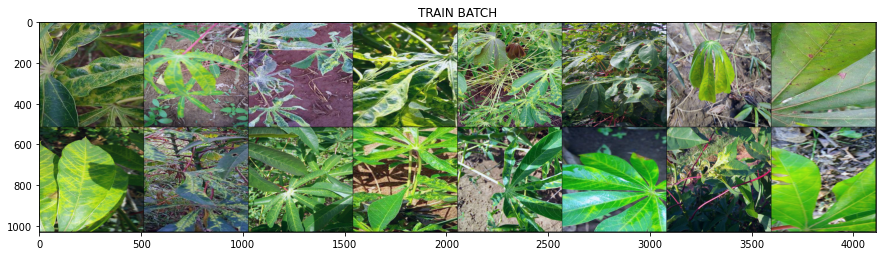

In [9]:
train_dl = model.train_dataloader()
ims, target = next(iter(train_dl))
grid = make_grid(ims[:16], normalize=True).permute(1, 2, 0).numpy()

plt.figure(figsize=(15,10))
plt.title("TRAIN BATCH")
plt.imshow(grid);

In [12]:
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.datasets.ipynb.
Converted 01a_data.mixmethods.ipynb.
Converted 01b_data.datasests_factory.ipynb.
Converted 02_losses.ipynb.
Converted 03_models.utils.ipynb.
Converted 03a_models.layers.ipynb.
Converted 03b_models.builder.ipynb.
Converted 03b_models.classifiers.ipynb.
Converted 03b_models.task.ipynb.
Converted 04_optimizers.ipynb.
Converted 04a_schedulers.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted index.ipynb.
